In [ ]:
#Create G-J templates from GAIA data crossed with 2Masss

In [11]:
%matplotlib inline
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import math

In [59]:
def cleanData(t,QFlags,Jmag,Kmag,Hmag,dup,Source):
    #Masks data values 
    
    # mask all data that does not have a Qfl value of A
    for i in range(0,len(QFlags)):
        if(QFlags[i][0] == ord("A")):
            Jmag.mask[i] = False
        else:
             Jmag.mask[i] = True
            
    for i in range(0,len(QFlags)):
        if(QFlags[i][2] == ord("A")):
            Kmag.mask[i] = False
        else:
            Kmag.mask[i] = True  
        
    for i in range(0,len(QFlags)):
        if(QFlags[i][1] == ord("A")):
            Hmag.mask[i] = False
        else:
            Hmag.mask[i] = True
    
    #mask all values with dup = 1
    imask = 0
    for i in range(0,len(dup)):
        if (dup[i] > 0.5):
            imask = imask + 1
            row = t[i]
            idx = row._index
            cols = row._table.columns.values()
            for col in cols:
                col.mask[i] = True
    for i in range(0,len(dup)):
        if(dup[i] > 0.5):
            print(i,dup[i])
    print("Masked ",imask," rows in which dup is equal to 1")
    
    #remove dupliacte matches
    Test = Source.compressed()
    unique = set()
    Gdups = set()

    for i in range(0,len(Test)):
        if(Test[i] in unique):
            print("GAIA Duplicate Source: ",Test[i])
            Gdups.add(Test[i])
        else:
            unique.add(Test[i])
            last = Test[i]
    print("Finished GAIA Duplicate Check. Found: ", len(Gdups))

    for i in range(0,len(Source)):
        if(Source.mask[i] == False):
            Name = Source[i]
            if(Name in Gdups):
                row = t[i]
                idx = row._index
                cols = row._table.columns.values()
                for col in cols:
                    col.mask[i] = True
    print("Finished masking all GAIA duplicates. All sources involved")
    TwoM = t["_2MASS"]
    unique = set()
    Tdups = set()
    Test = TwoM.compressed()
    for i in range(0,len(Test)):
        if(Test[i] in unique):
            print("2MASS Duplicate Source: ",Test[i])
            Tdups.add(Test[i])
        else:
            unique.add(Test[i])
            last = Test[i]
    print("Finished 2MASS Duplicate Check. Found: ", len(Tdups))

    for i in range(0,len(Source)):
        if(Source.mask[i] == False):
            Name = Source[i]
            if(Name in Tdups):
                print(Source[i],s1[i],s2[i],Gmag[i],Vmag[i]-Gmag[i],Jmag[i],Kmag[i],TwoM[i])
                
    #masked rows with J-G greater than 5 sigma from mean
    J_G = Jmag-Gmag
    JGmean = np.mean(J_G)
    JGstd = np.std(J_G)
    imask = 0
    for i in range(0,len(J_G)):
        if(abs(J_G[i] - JGmean) > 5*JGstd):
            imask = imask + 1
            row = t[i]
            idx = row._index
            cols = row._table.columns.values()
            for col in cols:
                col.mask[i] = True
    print("Masked ",imask," rows based on J-G color > 5 sigma from mean")
    
    return t

In [60]:
def LuminosityClasses(t,SpType):
    #Classifies the data into different luminosity classes

    SpTypeN = [0.0]*len(SpType)
    for i in range(0,len(SpType)):
        if(SpType.mask[i] == False):
            SpT = SpType[i].decode()
            if(len(SpT) > 2):
                for j in range(0,len(SpT)):
                    if(SpT[j] == 'I'):
                        SpTypeN[i] = SpTypeN[i] + 1
                    if(SpT[j] == 'V'):
                        SpTypeN[i] = SpTypeN[i] + 5
                    if(SpT[j] == '+'):
                        SpTypeN[i] = -20.
                
            else:
                SpTypeN[i] = 5.1
        
            if(SpTypeN[i] == 6):
                SpTypeN[i] = 4.
            if(SpTypeN[i] == 11):
                SpTypeN[i] = 4.5
            if(SpTypeN[i] == 9):
                SpTypeN[i] = 3.5
            if(SpTypeN[i] > 5.2):
                SpTypeN[i] = -30.
    print("Finished Luminosity Class Translation")
    count = 0
    for i in range(0,len(SpType)):
        if(SpTypeN[i] < 0.):
            count = count + 1
    test = SpType.compressed()
    good = len(test) - count
    print("Number of single Stars: ",good,"  Binaries or Unknown luminosity class: ",count)
    
    return t,SpTypeN

In [61]:
def AbsoluteMagnitudes(plx,Vmag,Bmag,Gmag,Jmag,Hmag,Kmag):
    #Calculate distance, and absolute magnitudes
    
    Dist = ma.array([])
    Vmags = ma.array([])
    Bmags = ma.array([])
    Gmags = ma.array([])
    Jmags = ma.array([])
    Hmags = ma.array([])
    Kmags = ma.array([])

    Dist = 1000./plx
    Vmags = Vmag - 5 * np.log10(Dist) + 5
    Bmags = Bmag - 5 * np.log10(Dist) + 5
    Gmags = Gmag - 5 * np.log10(Dist) + 5
    Jmags = Jmag -5 * np.log10(Dist) + 5
    Hmags = Hmag - 5 * np.log10(Dist) + 5
    Kmags = Kmag - 5 * np.log10(Dist) + 5
    
    return Dist,Vmags,Bmags,Gmags,Jmags,Hmags,Kmags

In [124]:
def ColorClassification(Gmags,Jmags):    
    #split the stars into different categories based on G-J
    
    G_J = Gmags-Jmags
    color = np.ones(len(G_J))*1000
    colors = np.arange(0.1,3,0.1)
    #colors = [0.5,1,1.5,2,2.5,3]
    for i in range(len(colors)):
        for j in range(len(G_J)):
            if (i == 0):
                if (G_J[j] <= colors[i]):
                    color[j] = colors[i]
            elif(G_J[j] <= colors[i] and G_J[j] > colors[i-1]):
                color[j] = colors[i]
    return color,colors

In [125]:
def CreateTemplates(color,colors,Vmags,Bmags,Gmags,Jmags,Hmags,Kmags):
    #for each color class, a template is created of the absolute magnitudes of the stars and their color indices
    
    G_J = Gmags-Jmags
    #wavelengths of color bands
    wvl = [420, 477, 1235, 1662, 2159]
    wvl2 = [420, 477, 673,1235, 1662, 2159]
    avg_colors = np.array([])
    err_colors = np.array([])
    stars = np.array([])
    for c in colors:
        #create array of values for color indices and absolute magnitudes
        G_B_array = ma.array([])
        G_V_array = ma.array([])
        G_J_array = ma.array([])
        G_H_array = ma.array([])
        G_K_array = ma.array([])
        B = ma.array([])
        V = ma.array([])
        G = ma.array([])
        J = ma.array([])
        H = ma.array([])
        K = ma.array([])
        star_count = 0
        #fill arrays with values if the values are part of the color category
        for i in range(len(G_J)):
            if (color[i] == c and SpTypeN[i] > 4.9 and SpTypeN[i] < 5.05):
                G_B_array = np.append(G_B_array,Gmags[i]-Bmags[i])
                G_V_array = np.append(G_V_array,Gmags[i]-Vmags[i])
                G_J_array = np.append(G_J_array,Gmags[i]-Jmags[i])
                G_H_array = np.append(G_H_array,Gmags[i]-Hmags[i])
                G_K_array = np.append(G_K_array,Gmags[i]-Kmags[i])
                B = np.append(B,Bmags[i])
                V = np.append(V,Vmags[i])
                G = np.append(G,Gmags[i])
                J = np.append(J,Jmags[i])
                H = np.append(H,Hmags[i])
                K = np.append(K,Kmags[i])
                star_count = star_count +1
        #average G-J value
        avg_colors = np.append(avg_colors,np.mean(G_J_array))
        err_colors = np.append(avg_colors,np.std(G_J_array))
        #number of stars per color
        stars = np.append(stars,star_count)
        #relative SED
        mag_array = [np.mean(G_B_array), np.mean(G_V_array),\
                     np.mean(G_J_array), np.mean(G_H_array), np.mean(G_K_array)]
        std_array = [np.std(G_B_array), np.std(G_V_array), \
                     np.std(G_J_array), np.std(G_H_array), np.std(G_K_array)]
        #absolute SED
        mag_array2 = [np.mean(B), np.mean(V), np.mean(G), \
                      np.mean(J), np.mean(H), np.mean(K)]
        std_array2 = [np.std(B), np.std(V), np.std(G), \
                      np.std(J), np.std(H), np.std(K)]
        #add standard deviation error
        val = np.sqrt(len(G_B_array))
        std_array = std_array/val
        val2 = np.sqrt(len(B))
        std_array2 = std_array2/val2
        #stack SEDs
        if (c == colors[0]):
            color_mags = np.array(mag_array)
            color_std = np.array(std_array)
            abs_color_mags = np.array(mag_array2)
            abs_color_std = np.array(std_array2)
        else:
            color_mags = np.vstack((color_mags,mag_array))
            color_std = np.vstack((color_std,std_array))
            abs_color_mags = np.vstack((abs_color_mags, mag_array2))
            abs_color_std = np.vstack((abs_color_mags, std_array2))
    return avg_colors,err_colors,color_mags,color_std,abs_color_mags,abs_color_std

In [126]:
def CreatePlots(colors,abs_colors_mags,abs_color_std,color_mags,color_std):
    #create SED and Relative SED plots
    
    wvl = [420, 477, 1235, 1662, 2159]
    wvl2 = [420, 477, 673,1235, 1662, 2159]
    
    #plot average absolute magnitude in each filter for each color 
    ax = plt.subplot(111)
    for i in range(len(colors)):
        ax.errorbar(wvl2, abs_color_mags[i,:], yerr = abs_color_std[i,:], linestyle = '-', marker = 'o',label = str(colors[i]))
    ax.set_xlabel('Effective Wavelength (nm)')
    ax.set_ylabel('Average Absolute Magnitude')
    ax.set_title('Spectral Energy Distribution for Main Sequence Stars')
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    #plot average color index in each filter for each color 
    ax2 = plt.subplot(111)
    for i in range(len(colors)):
        ax2.errorbar(wvl, color_mags[i,:], yerr = color_std[i,:], linestyle = '-', marker = 'o',label = str(colors[i]))
    ax2.set_xlabel('Effective Wavelength (nm)')
    ax2.set_ylabel('Average Color Index')
    ax2.set_title('Spectral Energy Distribution for Main Sequence Stars')
    box2 = ax.get_position()
    ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    return

In [127]:
from astropy.table import Table
t = Table.read('../../ijoncour/StandCat/Tgas200_Wright2003_2MASS_FinCat.vot', format='votable')

In [129]:
#Rename columns
Source = t["Source"]
Gmag = t["__Gmag_"]
Vmag = t["VTmag"]
Bmag = t["BTmag"]
Jmag = t["Jmag"]
Hmag = t["Hmag"]
Kmag = t["Kmag"]
QFlags = t["Qfl"]
DistW = t["Dist"]
s1= t["d_arcsec"]
s2 = t["d_arcsec_2"]
plx = t['Plx']
Teff = t['Teff']
e_Jmag = t['e_Jmag']
e_Kmag = t['e_Kmag']
e_Hmag = t['e_Hmag']
SpType = t["SpType"]
dup = t['Dup']   

In [130]:
#I get [IndexError: too many indices for array] if I do not reinput the table t? 

t = cleanData(t,QFlags,Jmag,Kmag,Hmag,dup,Source)
t,SpTypeN = LuminosityClasses(t,SpType)
Dist,Vmags,Bmags,Gmags,Jmags,Hmags,Kmags = AbsoluteMagnitudes(plx,Vmag,Bmag,Gmag,Jmag,Hmag,Kmag)
color,colors = ColorClassification(Gmags,Jmags)
avg_colors,err_colors,color_mags,color_std,abs_color_mags,abs_color_std = CreateTemplates(color,colors,Vmags,Bmags,Gmags,Jmags,Hmags,Kmags)

Masked  25429  rows in which dup is equal to 1
GAIA Duplicate Source:  6726788842835559552
GAIA Duplicate Source:  5140648418166947328
GAIA Duplicate Source:  2520020864918288896
GAIA Duplicate Source:  5959478126358758016
GAIA Duplicate Source:  6668487925962916480
GAIA Duplicate Source:  1214512606941823360
GAIA Duplicate Source:  4097002323363211776
GAIA Duplicate Source:  5769091159655753856
GAIA Duplicate Source:  6790250970359184768
GAIA Duplicate Source:  5123327399177495808
GAIA Duplicate Source:  6785793275342096256
GAIA Duplicate Source:  2498832038900176000
GAIA Duplicate Source:  5324415053561705216
GAIA Duplicate Source:  2067478096721765376
GAIA Duplicate Source:  4785096491234658304
GAIA Duplicate Source:  5447076227156166528
GAIA Duplicate Source:  6054493694983536384
GAIA Duplicate Source:  5133580860502607104
GAIA Duplicate Source:  452193638896601088
GAIA Duplicate Source:  1837550183626334848
GAIA Duplicate Source:  3248442439236776960
GAIA Duplicate Source:  439297

/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:5060:

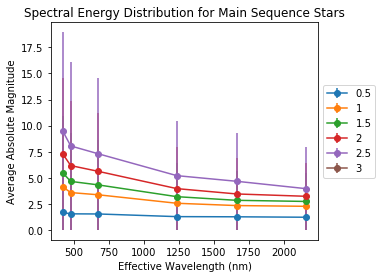

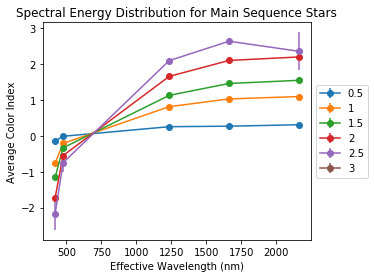

In [123]:
CreatePlots(colors,abs_color_mags,abs_color_std,color_mags,color_std)

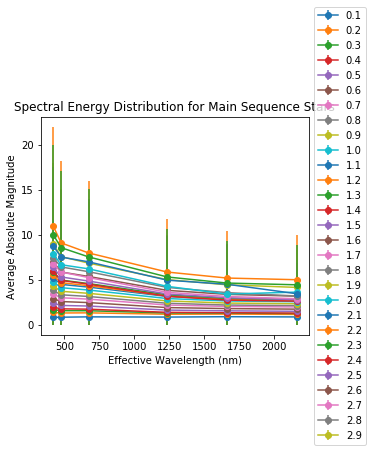

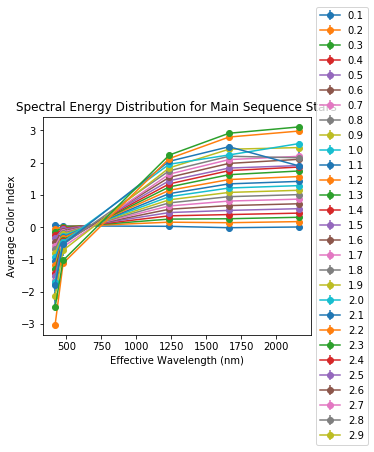

In [131]:
CreatePlots(colors,abs_color_mags,abs_color_std,color_mags,color_std)